In [1]:
import pandas as pd
import numpy as np

from datetime import datetime, timedelta,date
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

In [2]:
import plotly.express as px


In [4]:
df1=pd.read_csv('Year 2009-2010.csv',encoding='cp1252')
df2=pd.read_csv('Year 2010-2011.csv',encoding='cp1252')

In [11]:
# pyoff.init_notebook_mode()
# df=df1.append(df2)
# df.head()
df=pd.concat([df1, df2], axis=0, ignore_index=True)


In [12]:
df.shape

(1067371, 8)

In [13]:
print(df1.shape)
print(df2.shape)

(525461, 8)
(541910, 8)


In [14]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [15]:
df.dropna(axis=0,inplace=True)

In [16]:
x=df['Country'].value_counts().reset_index()

In [17]:
px.scatter(x, y = "Country", color = x.index) #checking for the occurence of most countries in our data

In [35]:
df['Country'].value_counts().head(5)

United Kingdom    741301
Germany            17624
EIRE               16195
France             14202
Netherlands         5140
Name: Country, dtype: int64

In [15]:
df['Invoice'].nunique()

44876

In [36]:
Top_prices= (df.groupby(["Invoice"]).mean().sort_values("Price", ascending = False).head(10).drop(['Quantity','Customer ID'], axis=1).reset_index())
Top_prices

C:\Users\dhruv\AppData\Local\Temp\ipykernel_17792\4028667197.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Invoice,Price
0,C556445,38970.00
1,C512770,25111.09
2,C502264,10953.50
3,502263,10953.50
4,C502262,10953.50
5,524159,10468.80
6,C522793,10468.80
7,C525398,10468.80
8,C496116,8985.60
9,496115,8985.60


In [17]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [18]:
df_analysis=df.copy()

In [19]:

df_analysis['Month'] = df_analysis['InvoiceDate'].dt.month
df_analysis['Month'] = df_analysis['InvoiceDate'].dt.month
df_analysis['Year'] = df_analysis['InvoiceDate'].dt.year
df_analysis['Day'] = df_analysis['InvoiceDate'].dt.day
df_analysis['Quarter'] = df_analysis['InvoiceDate'].dt.quarter
df_analysis['Day of Week'] = df_analysis['InvoiceDate'].dt.dayofweek


In [20]:
dayofweek_mapping = dict({0: "Monday", 1: "Tuesday", 
                         2: "Wednesday" ,  3: "Thursday", 
                         4: "Friday", 5: "Saturday", 6: "Sunday"})

In [21]:
df_analysis["Day of Week"] = df_analysis["Day of Week"].map(dayofweek_mapping)

### Make analysis plots for when products are bought

In [37]:
df_analysis

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Quarter,Day of Week
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,4,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,4,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,4,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,4,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,4,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12,2011,9,4,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12,2011,9,4,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12,2011,9,4,Friday
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,12,2011,9,4,Friday


In [38]:
snapshot_date = max(df_analysis['InvoiceDate']) +pd.DateOffset(days=1)

In [40]:
rfm = df_analysis.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',
    'Price': 'sum'
})

In [41]:
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'Price': 'MonetaryValue'}, inplace=True)

In [42]:
rfm.reset_index(inplace=True)
rfm.head()

,Customer ID,Recency,Frequency,MonetaryValue
0,12346.0,326,48,580.44
1,12347.0,2,253,644.16
2,12348.0,75,51,193.10
3,12349.0,19,180,1504.59
4,12350.0,310,17,65.30


In [43]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['MonetaryValue'], 4, labels=[1, 2, 3, 4])

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

rfm.head()


,Customer ID,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,48,580.44,2,2,4,224,8
1,12347.0,2,253,644.16,4,4,4,444,12
2,12348.0,75,51,193.10,3,2,3,323,8
3,12349.0,19,180,1504.59,4,4,4,444,12
4,12350.0,310,17,65.30,2,1,1,211,4


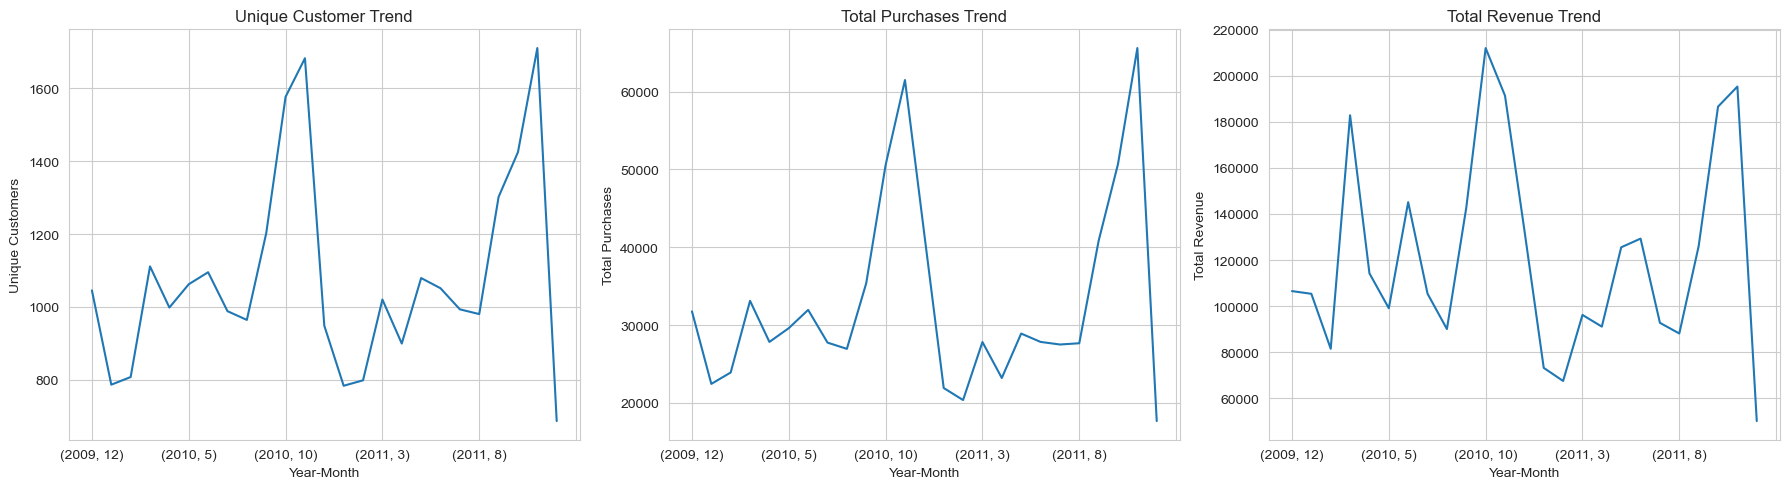

In [46]:
rfm_trend = df_analysis.groupby(['Year', 'Month']).agg({
    'Customer ID': pd.Series.nunique,
    'Invoice': 'count',
    'Price': 'sum'
}).reset_index()

rfm_trend.rename(columns={'Customer ID': 'Unique Customers', 'Invoice': 'Total Purchases', 'Price': 'Total Revenue'}, inplace=True)

rfm_pivot = rfm_trend.pivot_table(index=['Year', 'Month'], values=['Unique Customers', 'Total Purchases', 'Total Revenue'])
plt.figure(figsize=(18, 5))

# Unique Customers Trend
plt.subplot(1, 3, 1)
rfm_pivot['Unique Customers'].plot()
plt.title('Unique Customer Trend')
plt.xlabel('Year-Month')
plt.ylabel('Unique Customers')

# Total Purchases Trend
plt.subplot(1, 3, 2)
rfm_pivot['Total Purchases'].plot()
plt.title('Total Purchases Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Purchases')

# Total Revenue Trend
plt.subplot(1, 3, 3)
rfm_pivot['Total Revenue'].plot()
plt.title('Total Revenue Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Revenue')

plt.tight_layout()
plt.show()



1. **Unique Customer Trend**:
   - There's a noticeable peak around May 2010, after which the number of unique customers declines sharply.
   - A similar but smaller peak occurs around August 2011.
   - The lowest point seems to be around December 2009, and there's a general growth trend in unique customers from that point until May 2010.
   - After the peak in May 2010, there's a decline followed by a period of relative stability with minor fluctuations.

2. **Total Purchases Trend**:
   - Just like the unique customer trend, there's a sharp peak around May 2010, which is then followed by a steep decline.
   - There's also another peak around August 2011, though it's not as pronounced as the first one.
   - The trend between these two peaks shows a stable period with slight growth.

3. **Total Revenue Trend**:
   - The revenue trend is more volatile compared to the other two.
   - There are multiple peaks and valleys. The peaks occur around December 2009, May 2010, and August 2011. These peaks align well with the peaks in the other two graphs.
   - Interestingly, while the unique customers and total purchases show a decline post-May 2010, the total revenue doesn't drop as sharply. This could indicate that while fewer customers were making purchases, the average transaction value might have been higher.
   - The period post-August 2011 indicates a decline in revenue, which seems to stabilize towards the end of the graph.

**Analysis**:
- The peaks in May 2010 and August 2011 across all three graphs suggest that there might have been some marketing campaigns, events, or external factors that drove higher engagement during those times.
- Post the peak in May 2010, even though the number of unique customers and total purchases declined, the revenue didn't drop as drastically. This might be due to higher transaction values or selling more premium products/services during that period.
- It would be beneficial to understand external and internal business activities during these peak times to gain a better understanding of what drove the spikes and how they can potentially be replicated in the future.

In [44]:
segt_map = {
    r'[1-2][1-2][1-2]': 'Hibernating',
    r'[1-2][1-2][3-4]': 'At Risk',
    r'[1-2][3-4][1-2]': 'Can’t Lose Them',
    r'[1-2][3-4][3-4]': 'About To Sleep',
    r'[3-4][1-2][1-2]': 'Lost Cheap Customers',
    r'[3-4][1-2][3-4]': 'Lost Customers',
    r'[3-4][3-4][1-2]': 'Potential Loyalist',
    r'[3-4][3-4][3-4]': 'Champions'
}

rfm['Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

segment_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

segment_counts


Lost Customers            98
Can’t Lose Them          136
Potential Loyalist       143
At Risk                  196
About To Sleep           789
Lost Cheap Customers     848
Hibernating             1844
Champions               1888
Name: Segment, dtype: int64

1. **Top Customers (Champions)**: These customers have the highest RFM scores and are frequent, recent buyers with a high monetary value. They are likely to respond well to upselling and cross-selling opportunities.
2. **Loyal Customers**: Customers with high frequency but potentially lower recency and/or monetary scores. They buy often and are engaged with the brand.
3. **Potential Loyalist**: These are customers with a high monetary score and a good frequency but might not have shopped recently.
4. **Recent Customers**: Customers with high recency scores but lower frequency and monetary values. They are new customers that have the potential to become repeat buyers.
5. **At Risk**: Customers who have spent a lot and shopped often but haven't returned for a long time.
6. **Can’t Lose Them**: Once loyal and high-spending customers who haven’t made purchases in a long time.
7. **Hibernating**: Low recency, frequency, and monetary scores, indicating customers who used to shop but haven't engaged in a long time.
8. **Lost Customers**: The lowest RFM scores across all three dimensions. They are unlikely to return and may not be worth investing in reactivation efforts.

- **Champions**: 1888 customers
- **Hibernating**: 1844 customers
- **Lost Cheap Customers**: 848 customers
- **About To Sleep**: 789 customers
- **At Risk**: 196 customers
- **Potential Loyalist**: 143 customers
- **Can’t Lose Them**: 136 customers
- **Lost Customers**: 98 customers


## Analysis

- Offer exclusive promotions to "Champions" to reward their loyalty and encourage further engagement.
- Send loyalty programs or feedback requests to "Potential Loyalists" to increase their engagement and move them towards becoming "Champions".
- Create re-engagement campaigns for "At Risk" and "Can’t Lose Them" segments to encourage them to make another purchase.
- Approach "Hibernating" customers with special comeback deals or information on what's new since they last purchased.


In [53]:
# Identify returned transactions
returns_invoices = df_analysis[df_analysis['Invoice'].astype(str).str.contains('C')]
customer_return_rates = returns_invoices.groupby('Customer ID').size() / df_analysis.groupby('Customer ID').size()
customer_return_rates_df = customer_return_rates.reset_index().rename(columns={0: 'Return Rate'})
rfm_with_returns = rfm.merge(customer_return_rates_df, on='Customer ID', how='left')
rfm_with_returns['Return Rate'].fillna(0, inplace=True)
segment_profiles = rfm_with_returns.groupby('Segment').agg({
    'MonetaryValue': 'mean',
    'Frequency': 'mean',
    'Return Rate': 'mean'
}).reset_index()
segment_profiles



,Segment,MonetaryValue,Frequency,Return Rate
0,About To Sleep,547.390540,157.485425,0.023883
1,At Risk,1506.276173,32.285714,0.204524
2,Can’t Lose Them,139.747206,67.213235,0.016268
3,Champions,1088.344818,324.363877,0.024519
4,Hibernating,62.923477,19.787419,0.046673
5,Lost Cheap Customers,71.537219,24.949292,0.024114
6,Lost Customers,343.363990,41.836735,0.036041
7,Potential Loyalist,138.148112,73.391608,0.012119


1. **About To Sleep**: These customers have a moderate average monetary value and a high purchase frequency but have not purchased recently. The return rate is relatively low. Strategies for this group could focus on re-engagement campaigns to remind them of the brand and encourage them to return.

2. **At Risk**: This segment has a high average monetary value but a low purchase frequency and a significantly high return rate. These customers have spent a lot but are not purchasing frequently and when they do, they return items often. This could indicate dissatisfaction or issues with the products. It would be crucial to reach out to these customers with surveys or personalized communication to understand their issues and improve their customer experience.

3. **Can’t Lose Them**: Customers in this segment have a low average monetary value and an above-average frequency. The return rate is low, which suggests they are satisfied with their purchases. They might be buying less expensive items but doing so regularly. It would be beneficial to try to upsell or cross-sell to increase their average spend.

4. **Champions**: These are your best customers with high monetary value and high purchase frequency. They also have a low return rate, which indicates strong satisfaction with their purchases. Maintaining a good relationship with these customers is essential, and they could be targeted with loyalty programs, exclusive offers, or early access to new products.

5. **Hibernating**: These customers have the lowest average monetary value and frequency, and a relatively high return rate. They may be infrequent shoppers who are not highly engaged with the brand. Tailored promotions or feedback requests might be ways to revive interest among these customers.

6. **Lost Cheap Customers**: This segment has a low monetary value, low frequency, and low return rate. They have not spent much and do not purchase often. It might not be cost-effective to invest heavily in re-engaging this segment, but periodic low-cost promotions could be used to entice them back.

7. **Lost Customers**: With a moderate average monetary value and frequency, these customers have stopped purchasing recently. The return rate is higher than average, suggesting potential issues with product satisfaction. It might be worthwhile to investigate why these customers have stopped purchasing and address any service or product issues.

8. **Potential Loyalist**: This segment has a moderate average monetary value and high frequency. They have a very low return rate, which suggests they are recent customers who are happy with their purchases. These customers show the potential to become high-value customers, and efforts should be made to nurture these relationships through personalized marketing, recommendations, and loyalty programs.

Overall, each segment requires a different marketing and customer service strategy. High-value segments like Champions and Potential Loyalist should be the focus for retention and loyalty programs, while "At Risk" customers need attention to understand their dissatisfaction. For Hibernating and Lost segments, reactivation strategies are needed, possibly through re-engagement campaigns and feedback solicitation to identify any service or product improvement opportunities.

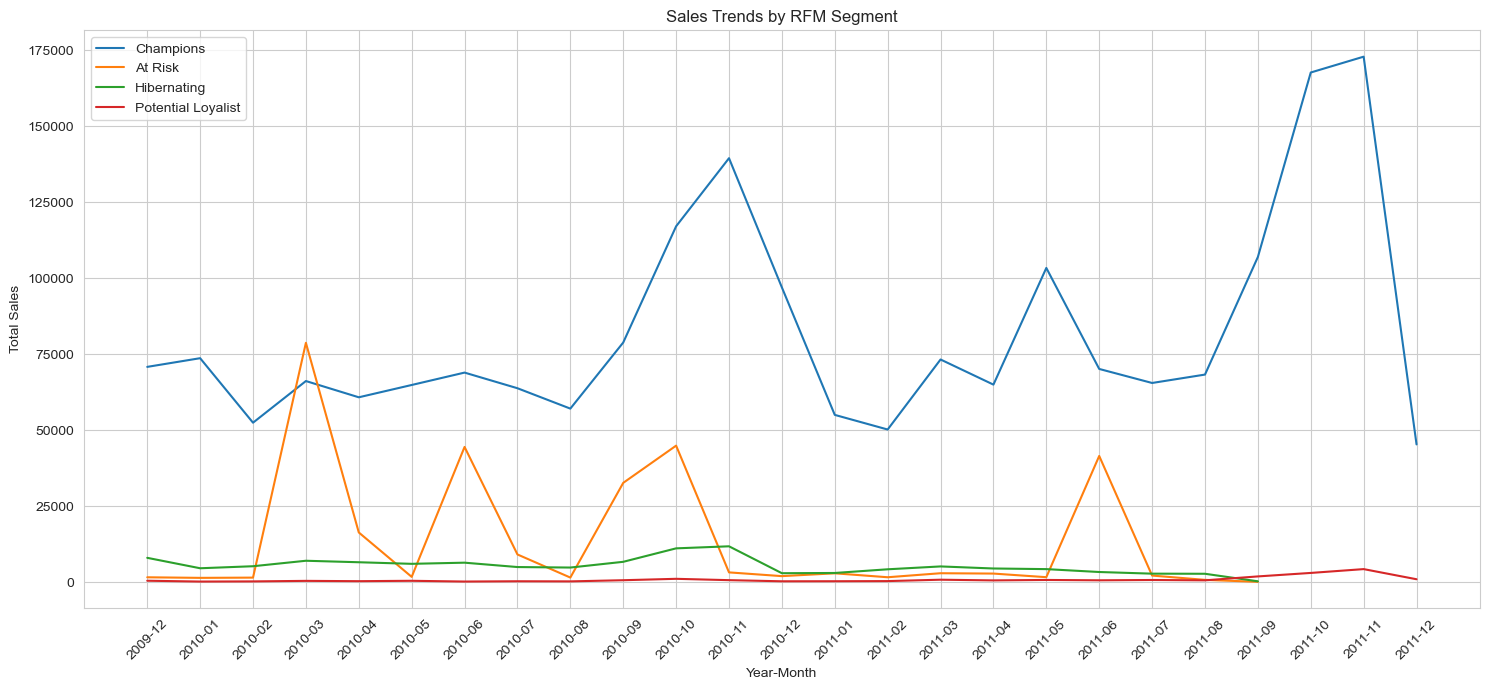

In [57]:
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['Segment'] = rfm['RFM_Segment'].replace(segt_map, regex=True)

df_analysis_with_segment = df_analysis.merge(rfm[['Customer ID', 'Segment']], on='Customer ID', how='left')

df_analysis_with_segment['YearMonth'] = df_analysis_with_segment['InvoiceDate'].dt.to_period('M')

time_series_data = df_analysis_with_segment.groupby(['YearMonth', 'Segment']).agg({
    'Price': 'sum',  
    'Invoice': 'nunique', 
    'Customer ID': 'nunique' 
}).reset_index()

time_series_pivot = time_series_data.pivot_table(index='YearMonth', columns='Segment', values='Price')

segments_to_plot = ['Champions', 'At Risk', 'Hibernating', 'Potential Loyalist']
time_series_pivot = time_series_pivot[segments_to_plot]

plt.figure(figsize=(15, 7))
for segment in segments_to_plot:
    plt.plot(time_series_pivot.index.astype(str), time_series_pivot[segment], label=segment)

plt.title('Sales Trends by RFM Segment')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()





1. **Champions (Blue Line)**:
   - The "Champions" segment consistently drives the highest sales throughout the entire time frame.
   - There are major peaks in sales around early 2010, mid-2011, and late 2021.
   - The most significant peak occurs around late 2021, with a sharp decline right after.
   - There are periods of relative stability, particularly between early 2011 and mid-2011 and from early 2014 to mid-2014.

2. **At Risk (Orange Line)**:
   - This segment has periodic spikes in sales, notably around early 2010, mid-2011, and mid-2013.
   - Post-mid-2013, sales from the "At Risk" segment have significantly declined and have remained low.

3. **Hibernating (Green Line)**:
   - Sales from the "Hibernating" segment are relatively consistent but at a much lower volume compared to the other segments.
   - There's a slight increase in sales around mid-2011 and mid-2013 but then returns to a low baseline.

4. **Potential Loyalist (Red Line)**:
   - This segment has the lowest sales across the time frame.
   - There's a minor peak around mid-2013, but sales have remained flat for the most part.

**General Observations**:
- **Volatility**: The "Champions" segment, despite its high sales, shows volatility with sharp peaks and valleys, suggesting potential seasonal trends or impacts from promotional campaigns.
- **Decline in At Risk**: The sales from the "At Risk" segment, which showed promise with intermittent peaks, has seen a decline post-mid-2013, suggesting a possible loss of engagement or change in buying behavior among this segment.
- **Consistency in Hibernating & Potential Loyalist**: These segments are relatively consistent in their sales trends, albeit at lower volumes. Efforts could be made to re-engage or upsell to these segments to tap into their potential.
- **Alignment of Peaks**: The peaks in sales across the segments align well, especially around early 2010, mid-2011, and mid-2013. This alignment suggests that external factors like marketing campaigns or seasonality might have influenced sales across all segments during these times.

In conclusion, while the Champions segment drives the most sales, there's room to engage the other segments better, especially the At Risk segment, which has shown potential in the past. It would be beneficial to explore strategies to re-engage the At Risk and Hibernating segments while maintaining the loyalty of the Champions segment.

In [58]:
summary = df_analysis.groupby('Customer ID').agg({
    'Invoice': 'nunique',  # Frequency
    'InvoiceDate': ['min', 'max'],
    'Price': 'sum'  # Total monetary value
}).reset_index()

summary.columns = ['Customer ID', 'Frequency', 'FirstPurchase', 'LastPurchase', 'MonetaryValue']

summary['Recency'] = (summary['LastPurchase'] - summary['FirstPurchase']).dt.days
summary['T'] = (snapshot_date - summary['FirstPurchase']).dt.days

summary['Frequency'] -= 1

summary = summary[summary['Frequency'] > 0]
summary['AverageValue'] = summary['MonetaryValue'] / summary['Frequency']

correlation = summary[['Frequency', 'AverageValue']].corr().iloc[0, 1]

correlation, summary[['Frequency', 'AverageValue']].head()


(-0.03243792531827793,
    Frequency  AverageValue
 0         16     36.277500
 1          7     92.022857
 2          4     48.275000
 3          4    376.147500
 6         12    188.808333)

The correlation between frequency and average monetary value is approximately 
−0.0324, which is very close to zero. This suggests that there is no significant relationship between the two variables, thus fulfilling the independence assumption required for the Gamma-Gamma model.

In [59]:
pip install lifetimes


     -------------------------------------- 584.2/584.2 kB 5.3 MB/s eta 0:00:00
     ---------------------------------------- 49.3/49.3 kB ? eta 0:00:00
     -------------------------------------- 115.3/115.3 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data


# Prepare the data for the CLV models
summary = summary_data_from_transaction_data(df, 'Customer ID', 'InvoiceDate', monetary_value_col='Price')

# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Check if the Gamma-Gamma model assumptions are met
summary = summary[summary['frequency'] > 0]
print(summary[['frequency', 'monetary_value']].corr())

# Fit the Gamma-Gamma model to the data
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(summary['frequency'], summary['monetary_value'])

# Estimate the average transaction value
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(1, summary['frequency'], summary['recency'], summary['T'])
summary['predicted_average_value'] = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])

# Calculate CLV using the DCF method (Discounted Cash Flow)
discount_rate = 0.01  
summary['CLV'] = ggf.customer_lifetime_value(bgf, summary['frequency'], summary['recency'], summary['T'], summary['monetary_value'],
                                             time=12,  # months
                                             discount_rate=discount_rate)


print(summary.head())



                frequency  monetary_value
frequency        1.000000        0.002185
monetary_value   0.002185        1.000000
             frequency  recency      T  monetary_value  predicted_purchases  \
Customer ID                                                                   
12346.0           10.0    400.0  634.0       57.594000             0.005742   
12347.0            5.0    275.0  313.0       87.338000             0.014649   
12348.0            3.0    190.0  347.0       36.196667             0.006976   
12349.0            3.0    328.0  644.0      139.576667             0.003586   
12352.0            5.0    130.0  301.0      388.444000             0.006330   

             predicted_average_value         CLV  
Customer ID                                       
12346.0                    60.058165  111.203910  
12347.0                    81.426985  373.845585  
12348.0                    51.578991  113.724965  
12349.0                   107.598834  125.045177  
12352.0       

In [61]:
summary

,frequency,recency,T,monetary_value,predicted_purchases,predicted_average_value,CLV
Customer ID,,,,,,,
12346.0,10.0,400.0,634.0,57.594000,0.005742,60.058165,111.203910
12347.0,5.0,275.0,313.0,87.338000,0.014649,81.426985,373.845585
12348.0,3.0,190.0,347.0,36.196667,0.006976,51.578991,113.724965
12349.0,3.0,328.0,644.0,139.576667,0.003586,107.598834,125.045177
12352.0,5.0,130.0,301.0,388.444000,0.006330,281.198687,556.687750
...,...,...,...,...,...,...,...
18282.0,1.0,4.0,35.0,0.290000,0.016419,50.124905,231.346751
18283.0,13.0,563.0,567.0,89.913846,0.021794,86.626058,605.733977
18284.0,1.0,2.0,340.0,25.000000,0.001161,57.112528,21.089557
